# 8회차: CNN을 활용한 컬러 이미지 분류 (2) – 데이터 처리 및 모델 구현


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

# 1. 데이터 전처리
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),    # 데이터 증강
    transforms.RandomCrop(32, padding=4), # 데이터 증강
    transforms.ToTensor(),                # 데이터 스케일 조정
    transforms.Normalize((0.4914, 0.4822, 0.4465), # 데이터 정규화
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = trainset.classes
classes

100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s]


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
len(trainset), len(testset)

(50000, 10000)

In [ ]:
# 2. CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            # 채널 수, 출력 필터인 feature map 수, 커널(필터)의 크기, 패딩 픽셀 수
            # 내부적으로 (채널 수 × feature map 수) 만큼의 커널(필터)를 생성
            # nn.Conv2d(3, 32, 3, padding=1),
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),

            # 학습 중에 각 채널(feature map)의 평균과 분산을 정규화
            # 학습 안정화, 수렴 속도 증가, 과적합 방지 효과
            nn.BatchNorm2d(32),

            # 비선형 활성화 함수 (Rectified Linear Unit)
            # 음수는 0, 양수는 그대로 통과
            nn.ReLU(),

            # 2×2 크기의 창(window)을 사용해, 그 안에서 최댓값만 추출
            # 32×32 → 16×16로 줄어듦
            nn.MaxPool2d(2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 16×16 → 8×8로 줄어듦
            nn.MaxPool2d(2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 8×8 → 4×4로 줄어듦
            nn.MaxPool2d(2))

        self.fc = nn.Linear(128 * 4 * 4, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
# 3. 모델 준비 및 구조 출력
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SimpleCNN().to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
        MaxPool2d-12            [-1, 128, 4, 4]               0
           Linear-13                   [-1, 10]          20,490
Total params: 114,186
Trainable params:

### 8-9회 전체 코드

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
        MaxPool2d-12            [-1, 128, 4, 4]               0
           Linear-13                   [-1, 10]          20,490
Total params: 114,186
Trainable params:

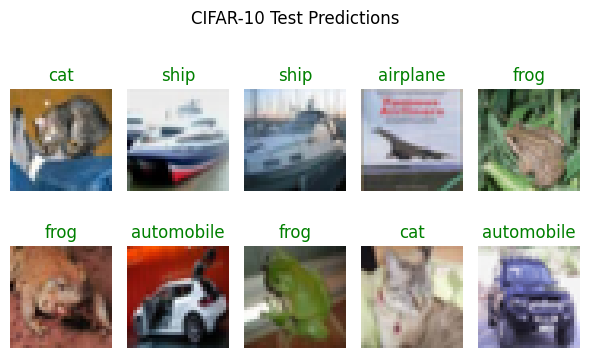

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),    # 데이터 증강
    transforms.RandomCrop(32, padding=4), # 데이터 증강
    transforms.ToTensor(),                # 데이터 스케일 조정
    transforms.Normalize((0.4914, 0.4822, 0.4465), # 데이터 정규화
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = trainset.classes

# 2. CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            # 채널 수, 출력 필터인 feature map 수, 커널(필터)의 크기, 패딩 픽셀 수
            # 내부적으로 (채널 수 × feature map 수) 만큼의 커널(필터)를 생성
            # nn.Conv2d(3, 32, 3, padding=1),
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),

            # 학습 중에 각 채널(feature map)의 평균과 분산을 정규화
            # 학습 안정화, 수렴 속도 증가, 과적합 방지 효과
            nn.BatchNorm2d(32),

            # 비선형 활성화 함수 (Rectified Linear Unit)
            # 음수는 0, 양수는 그대로 통과
            nn.ReLU(),

            # 2×2 크기의 창(window)을 사용해, 그 안에서 최댓값만 추출
            # 32×32 → 16×16로 줄어듦
            nn.MaxPool2d(2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 16×16 → 8×8로 줄어듦
            nn.MaxPool2d(2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 8×8 → 4×4로 줄어듦
            nn.MaxPool2d(2))

        self.fc = nn.Linear(128 * 4 * 4, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# 3. 모델 준비 및 구조 출력
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SimpleCNN().to(device)
summary(net, (3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_losses = []
test_accuracies = []

# 4. 학습 루프
for epoch in range(10):
    net.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

    # 정확도 계산
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f'[Epoch {epoch+1}] Loss: {avg_loss:.3f} | Test Accuracy: {accuracy:.2f}%')

# 5. 테스트 정확도 및 예측 수집
net.eval()
correct = 0
total = 0
all_preds = []
all_images = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_images.extend(inputs.cpu())
        all_labels.extend(labels.cpu())

print(f'Test Accuracy: {100 * correct / total:.2f}%')

# 6. 시각화 함수
def imshow(img):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    img = img * std + mean  # 역정규화
    img = img.numpy()
    img = np.clip(img, 0, 1)  # 범위 제한
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')

# 7. 예측 결과 시각화 (10개)
fig = plt.figure(figsize=(6, 4))
for idx in range(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow(all_images[idx])
    ax.set_title(f"{classes[all_preds[idx]]}",
                 color=('green' if all_preds[idx]==all_labels[idx] else 'red'))
plt.suptitle("CIFAR-10 Test Predictions")
plt.tight_layout()
plt.show()

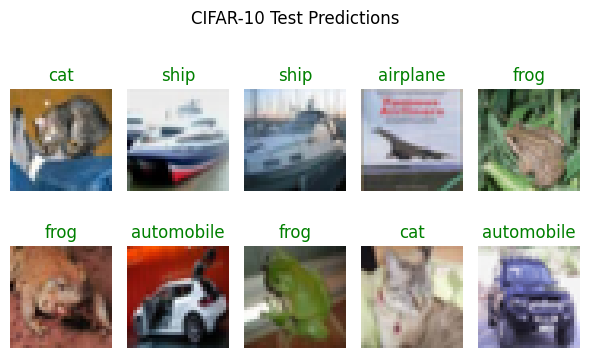

In [ ]:
# 6. 시각화 함수
def imshow(img):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    img = img * std + mean  # 역정규화
    img = img.numpy()
    img = np.clip(img, 0, 1)  # 범위 제한
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')

# 7. 예측 결과 시각화 (10개)
fig = plt.figure(figsize=(6, 4))
for idx in range(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow(all_images[idx])
    ax.set_title(f"{classes[all_preds[idx]]}",
                 color=('green' if all_preds[idx]==all_labels[idx] else 'red'))
plt.suptitle("CIFAR-10 Test Predictions")
plt.tight_layout()
plt.show()

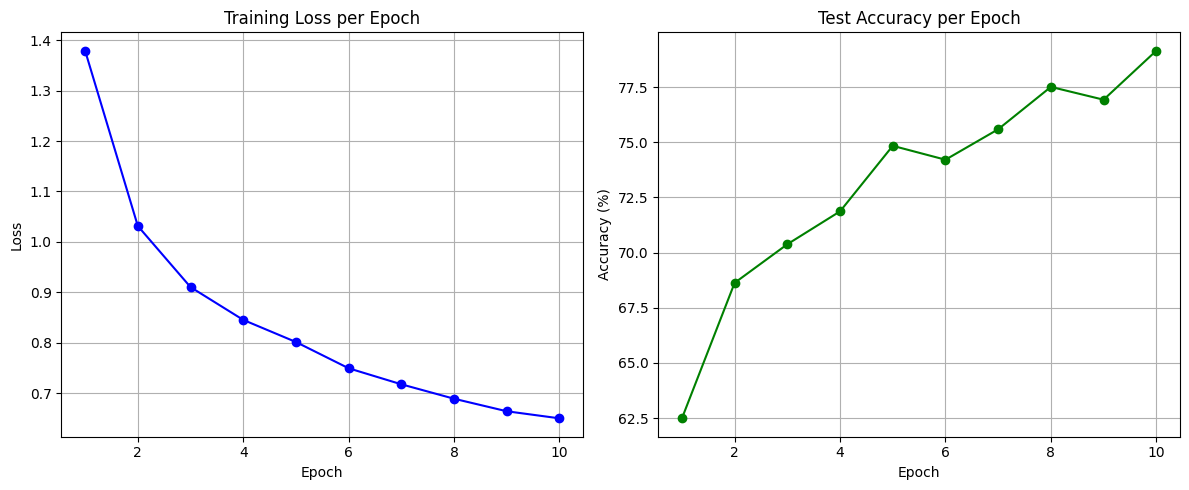

In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # 1. 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # 2. 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, 'g-o')
    plt.title('Test Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 학습 루프 이후에 아래 한 줄 추가하면 됨
plot_training_results(train_losses, test_accuracies)

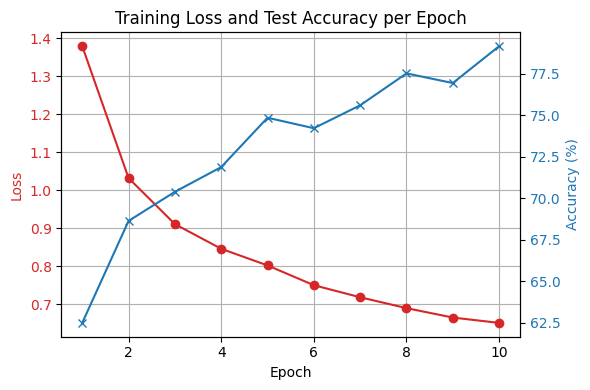

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy_together(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    fig, ax1 = plt.subplots(figsize=(6, 4))

    # 왼쪽 Y축: 손실
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, train_losses, color=color, marker='o', label='Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    # 오른쪽 Y축: 정확도
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy (%)', color=color)
    ax2.plot(epochs, test_accuracies, color=color, marker='x', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Training Loss and Test Accuracy per Epoch')
    fig.tight_layout()
    plt.show()

plot_loss_and_accuracy_together(train_losses, test_accuracies)


### CIFAR-10 데이터셋

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# 1. 변환 정의
transform = transforms.ToTensor()

# 2. CIFAR-10 데이터셋 불러오기
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 3. 데이터셋 통계
total_train = len(trainset)
total_test = len(testset)
class_names = trainset.classes  # 클래스 이름

# 4. 이미지 하나 꺼내서 shape 확인
sample_image, sample_label = trainset[0]
image_shape = sample_image.shape  # torch.Size([3, 32, 32])

# 5. 출력
print("CIFAR-10 Dataset 정보")
print(f"Train Set Size: {total_train}장")
print(f"Test Set Size: {total_test}장")
print(f"총 이미지 수: {total_train + total_test}장")
print(f"클래스 수: {len(class_names)}개")
print("클래스 목록:", class_names)
print(f"예시 이미지 크기: {image_shape} (채널, 높이, 너비)")
print(f"예시 이미지 라벨: {sample_label} ({class_names[sample_label]}) ")

100%|██████████| 170M/170M [00:03<00:00, 49.3MB/s]


CIFAR-10 Dataset 정보
Train Set Size: 50000장
Test Set Size: 10000장
총 이미지 수: 60000장
클래스 수: 10개
클래스 목록: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
예시 이미지 크기: torch.Size([3, 32, 32]) (채널, 높이, 너비)
예시 이미지 라벨: 6 (frog) 


In [ ]:
%config InlineBackend.figure_format = 'retina'

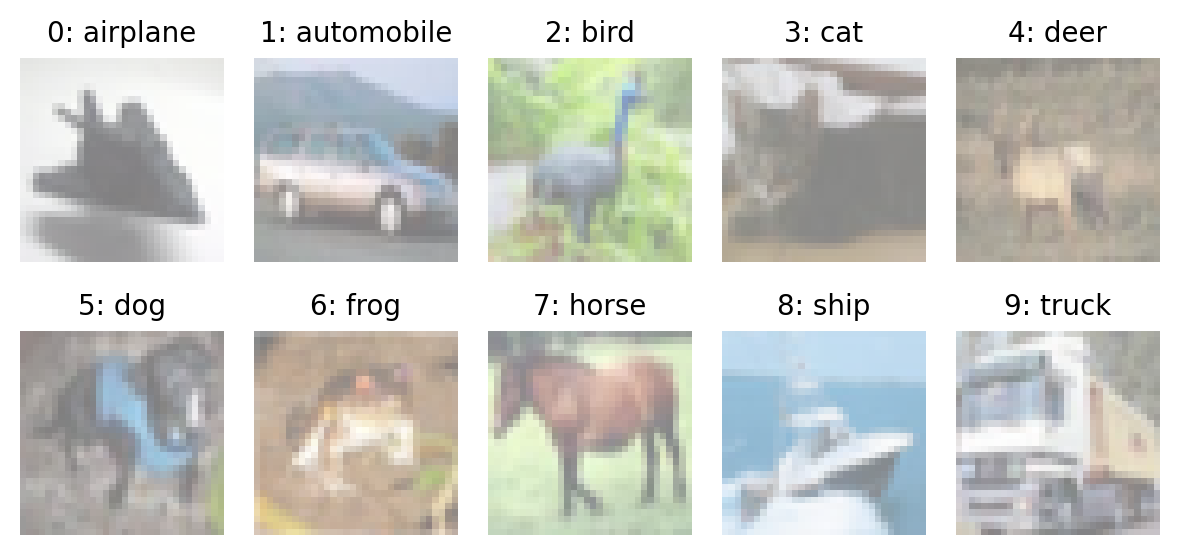

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch

# 1. CIFAR-10 데이터셋 불러오기
transform = transforms.ToTensor()
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 2. 클래스 이름과 초기화
class_names = trainset.classes
class_found = [False] * 10
images_to_show = [None] * 10

# 3. 각 클래스(0~9)마다 하나씩 이미지 수집
for image, label in trainset:
    if not class_found[label]:
        images_to_show[label] = image
        class_found[label] = True
    if all(class_found):
        break

# 4. 시각화: 2행 5열에 클래스 번호와 이름 함께 표시
plt.figure(figsize=(6, 3))
for i in range(10):
    img = images_to_show[i].permute(1, 2, 0)  # (C, H, W) → (H, W, C)
    img = img * 0.5 + 0.5  # 정규화 해제

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"{i}: {class_names[i]}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 종료